In [1]:
from typing import List, Optional, NamedTuple, Literal

import collections
import itertools
import functools
import json
import math
import os
import sys
import pathlib
import datetime
import hashlib
import pickle

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy
import statsmodels.stats.multitest
import cellrank

In [2]:
sys.path.insert(0, "../lib/")

In [3]:
import sc_utils

In [4]:
%config InlineBackend.figure_format = "retina"

In [5]:
mpl.rcParams["figure.figsize"] = (10, 8)
cellrank.settings.verbosity = 2
pd.options.display.max_columns = 200

In [6]:
FONT_DIR = '/projects/b1038/Pulmonary/nmarkov/fonts'
for f in os.listdir(FONT_DIR):
    if f.endswith('.ttf'):
        mpl.font_manager.fontManager.addfont(f'{FONT_DIR}/{f}')

In [7]:
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["pdf.fonttype"] = 42
# plt.rcParams['figure.constrained_layout.use'] = False
# mpl.rcParams['mathtext.default'] = 'regular'

In [8]:
DATA = pathlib.Path('../../data/31_bal-object/')

In [9]:
ds_processed = sc.read_h5ad(DATA / '03_bal-object/03_bal-object.h5ad')

In [10]:
ds_processed.obs.cell_type = ds_processed.obs.cell_type.astype(str).replace({
    'MoAM-3 mature': 'MoAM-2',
    'MoAM-4 profibrotic': 'MoAM-3 profibrotic',
    'gd/NKT cells': 'NK + γδT cells',
    'Perivascular macrophages': 'Interstitial macrophages',
}).astype('category')

In [11]:
rng = np.random.default_rng(seed=101)
ds_processed.uns['cell_type_colors'] = list(rng.permutation(
    ds_processed.uns['cell_type_colors']
))

In [12]:
paper_ids = pd.read_csv('../SSc_BAL_GEO_ID_Mapping - ID mapping.csv')

In [21]:
ds_processed.obs['paper_id'] = paper_ids.set_index('External Sample ID')['Publication ID'][
    ds_processed.obs['External Sample ID'].values
].values
ds_processed.obs['paper_id'] = pd.Categorical(ds_processed.obs['paper_id'])

In [14]:
cellrank._utils._linear_solver._is_petsc_slepc_available()

True

In [15]:
def get_color_annotations(df, mapping):
    result = []
    for column, palette in mapping.items():
        values = df[column].unique()
        if pd.api.types.is_categorical_dtype(df[column]):
            values = df[column].cat.categories
        lut = dict(zip(values, sns.color_palette(palette, n_colors=values.size).as_hex()))
        result.append(df[column].map(lut))
    return pd.concat(result, axis=1)

In [16]:
ds = ds_processed

In [17]:
ds

AnnData object with n_obs × n_vars = 197208 × 1000
    obs: 'Study', 'Sample', 'Sample ID', 'External Sample ID', 'Status', 'Patient', 'Age', 'Sex', 'Smoking status', 'Race', 'BMI', 'Type', 'Tissue location', 'Additional data', 'Chemistry', 'Protocol', 'Fastq', 'Genome build', 'Directory', 'Doublet threshold', 'batch', 'n_counts', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'cell_type', 'paper_id'
    var: 'feature_types', 'n_counts', 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi', 'cell_type_colors', 'hvg', 'leiden', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'dist

# 1. Myeloid object excluding DCs PAGA and Diffusion componets

Load processed cellrank object

In [18]:
myeloid = sc.read_h5ad('../../data/31_bal-object/13_cellrank/13_cellrank.h5ad')

In [19]:
myeloid.obs.cell_type = myeloid.obs.cell_type.astype(str).replace({
    'MoAM-3 mature': 'MoAM-2',
    'MoAM-4 profibrotic': 'MoAM-3 profibrotic',
    'gd/NKT cells': 'NK + γδT cells',
    'Perivascular macrophages': 'Interstitial macrophages',
}).astype('category')

In [20]:
myeloid.obs['paper_id'] = paper_ids.set_index('External Sample ID')['Publication ID'][
    myeloid.obs['External Sample ID'].values
].values
myeloid.obs['paper_id'] = pd.Categorical(myeloid.obs['paper_id'])

In [22]:
with open('../../data/31_bal-object/13_cellrank/13_cellrank.gpcca.pickle', 'rb') as f:
    g = pickle.load(f)

In [26]:
g.adata.obs['paper_id'] = paper_ids.set_index('External Sample ID')['Publication ID'][
    g.adata.obs['External Sample ID'].values
].values
g.adata.obs['paper_id'] = pd.Categorical(g.adata.obs['paper_id'])

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/cellrank_venv/lib/python3.11/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/cellrank_venv/lib/python3.11/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/cellrank_venv/lib/python3.11/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/cellrank_venv/lib/python3.11/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c

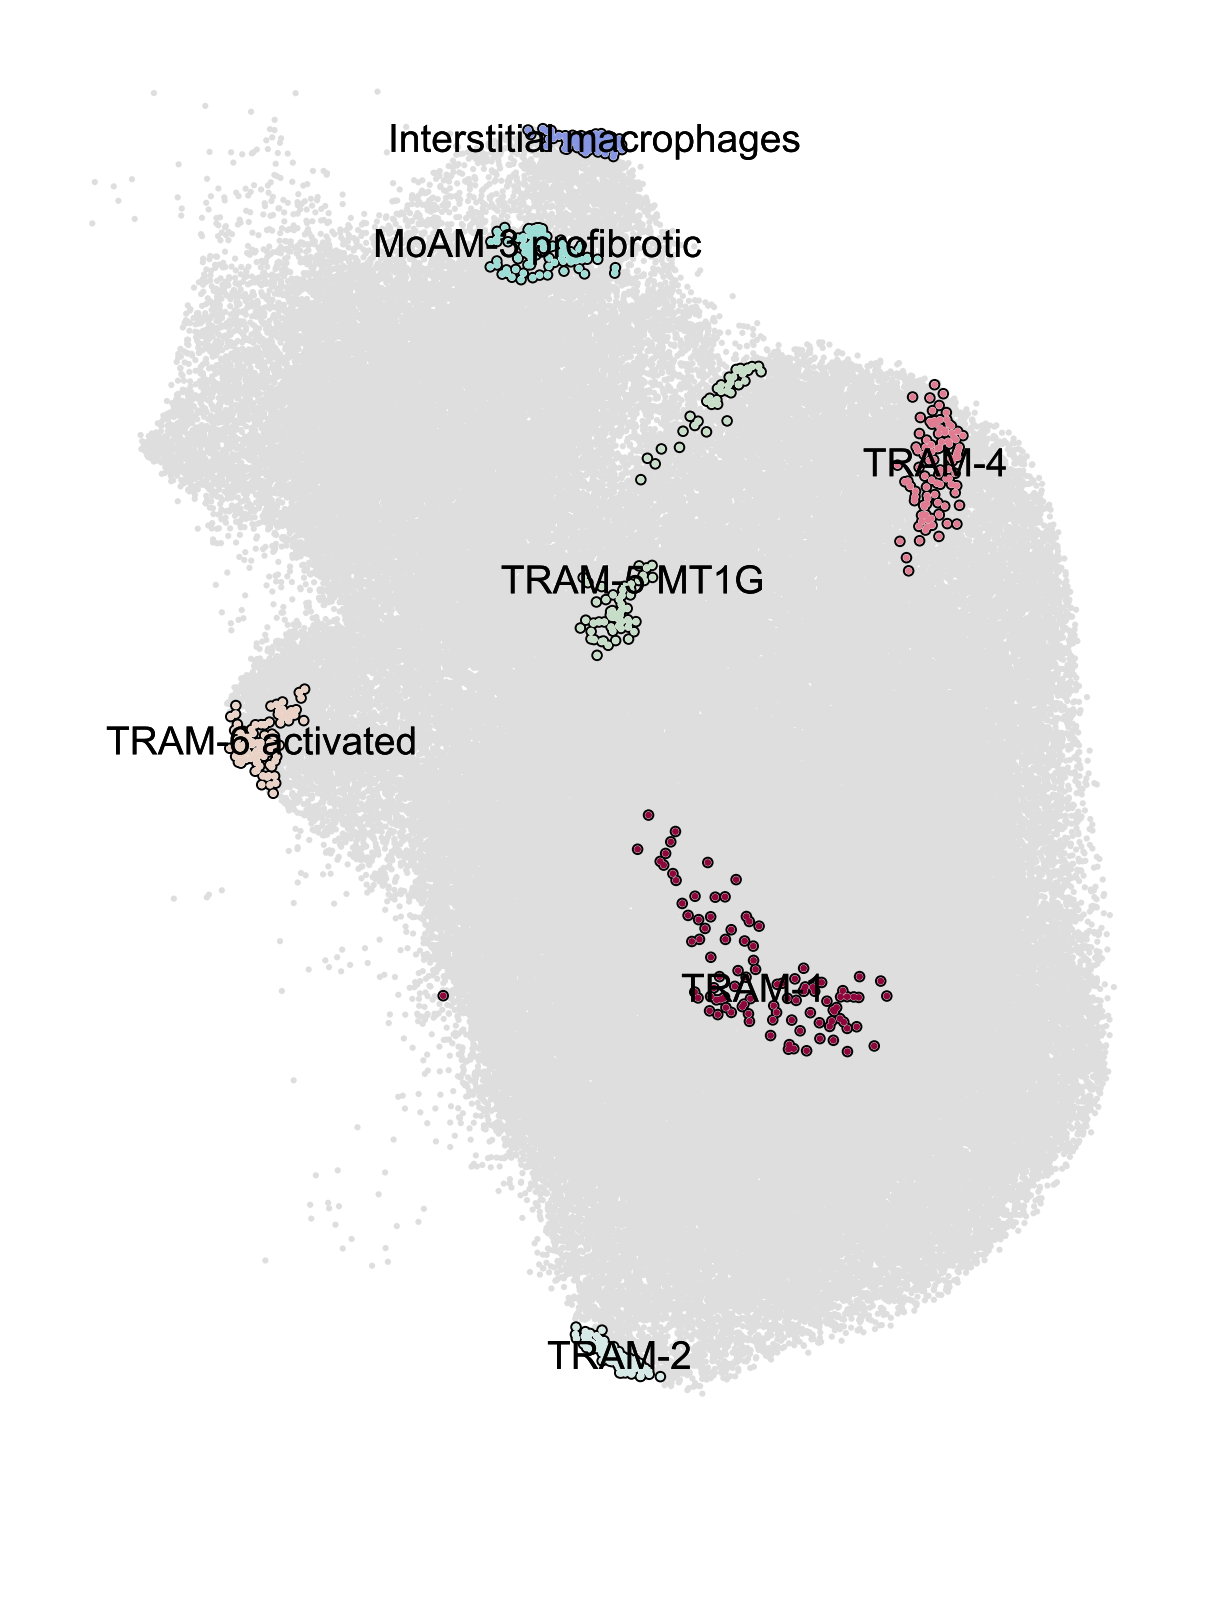

In [24]:
fig, ax = plt.subplots(figsize=(6, 8), constrained_layout=True)
g.plot_macrostates(
    which='all',
    # legend_loc='right',
    legend_fontweight='normal',
    legend_fontsize=14,
    legend_fontoutline=False,
    s=20,
    ax=ax,
    show=False,
    title=''
)
ax.set_xlim(3.5)
ax.collections[0].set_rasterized(True)
# h, l = ax.get_legend_handles_labels()
# ax.legend(
#     handles=h,
#     labels=l,
#     loc='upper right',
#     frameon=False
# )
# for lh in ax.legend_.legend_handles:
#     lh.set(alpha=1, sizes=[100], ec='#333', lw=0.5)
fig.savefig('00_figures/Figure_4A_stable_states.pdf', dpi=300)

In [25]:
myeloid.uns['Status_colors'] = ['royalblue', 'firebrick']
myeloid.obs.Status = myeloid.obs.Status.replace({
    'SSc': 'SSc-ILD',
    'control': 'Control'
})
myeloid.obs.Status = pd.Categorical(myeloid.obs.Status, categories=['Control', 'SSc-ILD'])

In [23]:
g._macrostates = g._macrostates._replace(
    assignment=g._macrostates.assignment.cat.reorder_categories([
        'MoAM-3 profibrotic',
        'TRAM-1', 'TRAM-2', 'TRAM-4', 'TRAM-5 MT1G', 'TRAM-6 activated',
        'Interstitial macrophages',
    ])
)

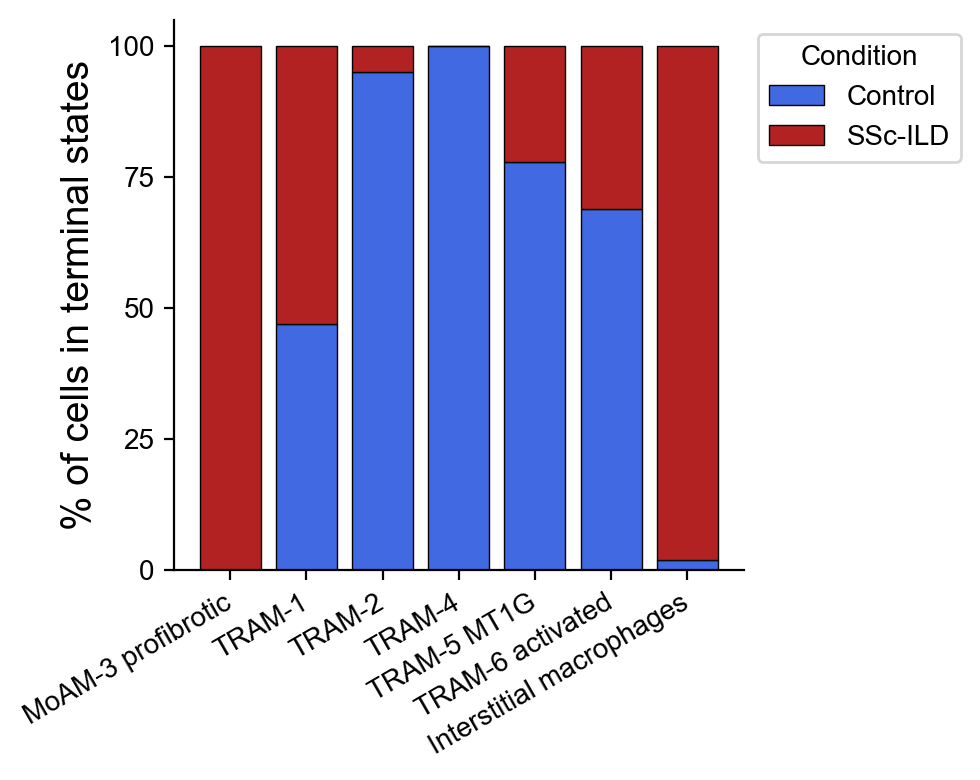

In [35]:
ax = g.plot_macrostate_composition(key='Status', show=False, figsize=(5, 4))
ax.set_title('')
ax.set_ylabel('% of cells in terminal states', size=14)
h, l = ax.get_legend_handles_labels()
ax.legend(handles=h, labels=l, title='Condition', loc='upper left', bbox_to_anchor=(1, 1))
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.xaxis.get_ticklabels():
    t.set_ha('right')
    t.set_transform(t.get_transform() + trans)
    t.set_rotation(30)
ax.set_xlabel('')
ax.spines[['top', 'right']].set_visible(False)
ax.figure.savefig('00_figures/Figure_S4A_term_states_by_cond.pdf')

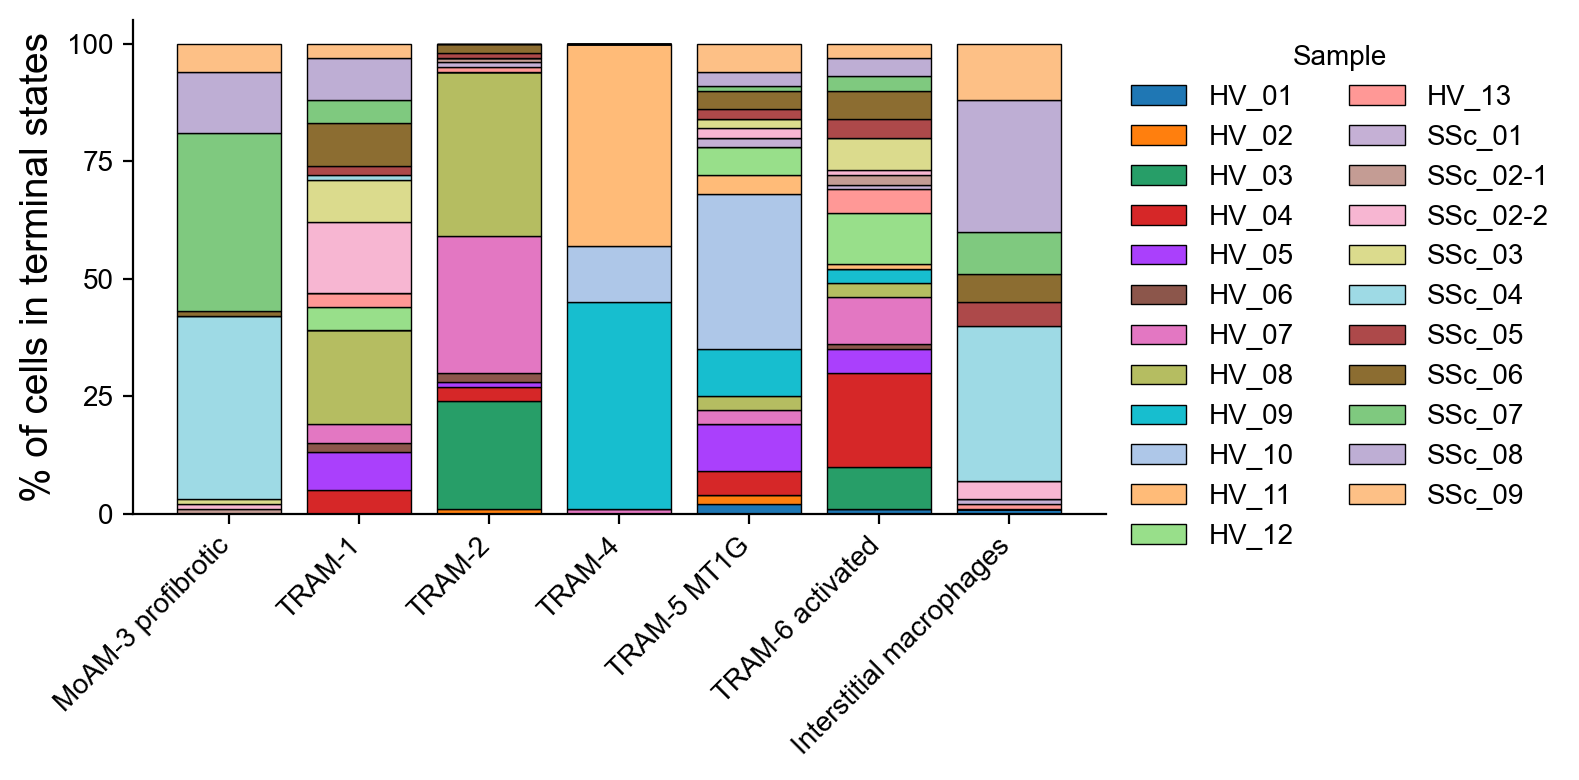

In [27]:
# Plot macrostate composition by patient
ax = g.plot_macrostate_composition(key='paper_id', show=False, figsize=(8, 4))
ax.set_title('')
ax.set_ylabel('% of cells in terminal states', size=14)
ax.set_xlabel('')

# Rotate x-axis labels for better readability
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.xaxis.get_ticklabels():
    t.set_ha('right')
    t.set_transform(t.get_transform() + trans)
    t.set_rotation(45)

# Clean up plot appearance
ax.spines[['top', 'right']].set_visible(False)
h, l = ax.get_legend_handles_labels()
ax.legend(handles=h, labels=l, title='Sample',
          loc='upper left', bbox_to_anchor=(1, 1), frameon=False, ncol=2)

# Save figure
ax.figure.savefig('00_figures/Figure_S4B_term_states_by_patient.pdf', bbox_inches='tight')

## Pseudobulk of fate probabilities

In [44]:
metadata_df = myeloid.obs[
    ['External Sample ID', 'cell_type', 'Status']
].groupby(['External Sample ID', 'cell_type', 'Status'], observed=True).size().reset_index(name='n_cells')

In [45]:
metadata_df = metadata_df.loc[metadata_df.n_cells.ge(10) & metadata_df.cell_type.isin([
    'Monocytes', 'MoAM-1', 'MoAM-2'
])]

In [46]:
metadata_df.Status = metadata_df.Status.cat.reorder_categories(['Control', 'SSc-ILD'])
metadata_df.cell_type = metadata_df.cell_type.cat.remove_unused_categories().cat.reorder_categories([
    'Monocytes', 'MoAM-1', 'MoAM-2'
])

In [47]:
pseudobulk = np.zeros((metadata_df.shape[0], myeloid.obsm['lineages_fwd'].shape[1]))
for i, (_, metadata_row) in enumerate(metadata_df.iterrows()):
    metadata_idx = (
        myeloid.obs.cell_type.eq(metadata_row.cell_type)
        & myeloid.obs['External Sample ID'].eq(metadata_row['External Sample ID'])
    )
    pseudobulk[i, :] = myeloid.obsm['lineages_fwd'][metadata_idx.to_numpy()].mean(axis=0)

In [60]:
pseudobulk = pd.DataFrame(pseudobulk, index=metadata_df.index, columns=g.terminal_states_memberships._names)

In [61]:
pseudobulk.shape

(65, 4)

In [62]:
sample_order = metadata_df.sort_values(
    ['Status', 'cell_type', 'External Sample ID']
).index

In [69]:
def plot_stats_boxplot(ax, df, value_col):
    stats_results = []
    for ct in df.cell_type.unique():
        vals1 = df[value_col][df.cell_type.eq(ct) & df.Status.eq('Control')]
        vals2 = df[value_col][df.cell_type.eq(ct) & df.Status.eq('SSc-ILD')]
        if vals1.size == 0 or vals2.size == 0:
            continue
        pval = scipy.stats.ttest_ind(vals1, vals2).pvalue
        stats_results.append([ct, 'Control', 'SSc-ILD', vals1.size, vals2.size, pval])

    stats_results = pd.DataFrame(
        stats_results,
        columns=['cell_type', 'group1', 'group2', 'group1_size', 'group2_size', 'pval']
    )
    stats_results['padj'] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval)[1]
    stats_results_sign = stats_results.loc[stats_results.padj.lt(0.05)]

    sns.boxplot(
        data=df,
        x='cell_type',
        y=value_col,
        hue='Status',
        palette=['royalblue', 'firebrick'],
        saturation=1,
        showfliers=False,
        linecolor='k',
        ax=ax,
        gap=0.2
    )
    sns.swarmplot(
        data=df,
        x='cell_type',
        y=value_col,
        hue='Status',
        dodge=True,
        palette=['k', 'k'],
        # jitter=0.2,
        legend=False,
        ax=ax
    )
    plotter = sns.categorical._CategoricalPlotter(
        data=df,
        variables=dict(x='cell_type', y=value_col, hue='Status')
    )
    plotter.scale_categorical(plotter.orient, order=None, formatter=None)
    plotter._attach(ax)

    start_height = df[value_col].max()
    incrementer = 15 # px
    q = ax.transData.inverted().transform([[0, 0], [0, incrementer]])
    y_offset = q[1][1] - q[0][1]
    gap = y_offset * 2
    y = start_height + gap
    for _, r in stats_results_sign.iterrows():
        p = f'$q={r.padj:.3f}$'

        # statistical annotation
        # Get x positions from Seaborn
        base_x = ax.xaxis.convert_units(r.cell_type)
        plotter_data = pd.DataFrame({plotter.orient: [base_x], "width": 0.8 * plotter._native_width})
        plotter._dodge({'hue': r.group1}, plotter_data)
        x1 = plotter_data[plotter.orient][0]
        plotter_data = pd.DataFrame({plotter.orient: [base_x], "width": 0.8 * plotter._native_width})
        plotter._dodge({'hue': r.group2}, plotter_data)
        x2 = plotter_data[plotter.orient][0]

        col = 'k'
        h = y_offset
        # y += gap

        bracket = ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
        txt = ax.text((x1+x2)*.5, y+1.1*h, p, ha='center', va='bottom', color=col, size=10)
        # y += y_offset

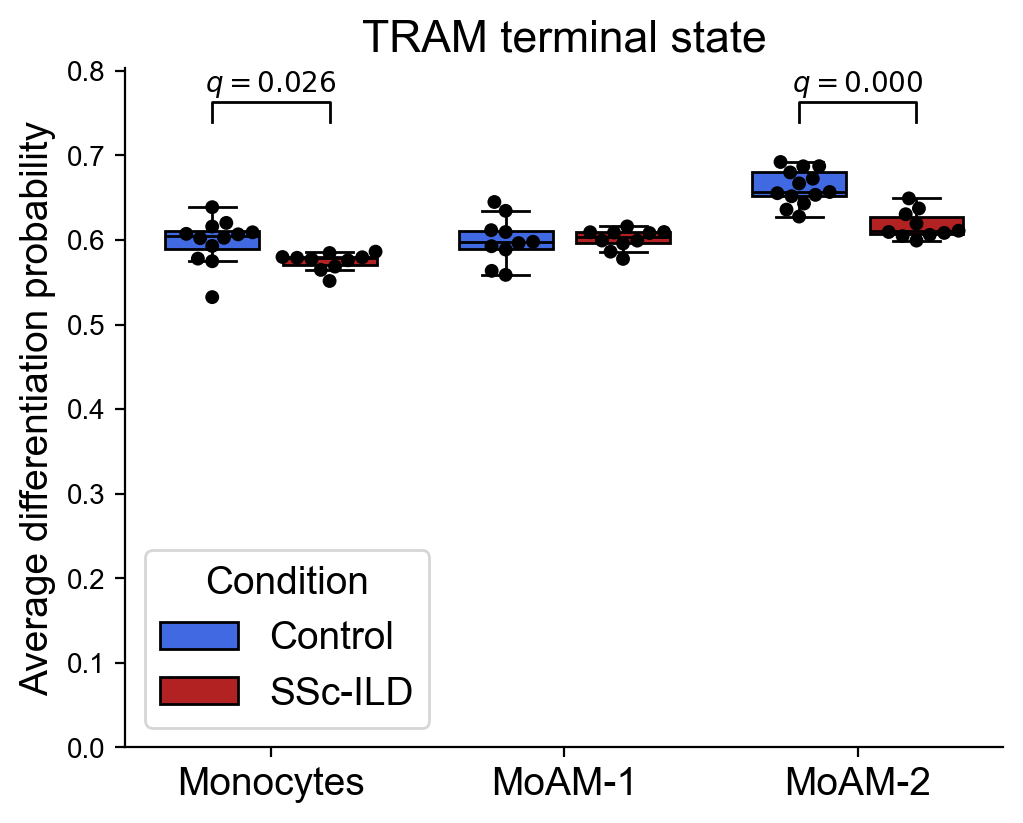

In [77]:
fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
LINEAGE = 'TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G'
df = pseudobulk.merge(metadata_df, left_index=True, right_index=True)
ax.set_ylim(0, df[LINEAGE].max() * 0.8)
plot_stats_boxplot(ax, df, LINEAGE)
ax.set_title(f'TRAM terminal state', size=16)
ax.set_ylabel(f'Average differentiation probability', size=14)
ax.set_xlabel('')
ax.tick_params(axis='x', labelsize=14)
ax.set_ylim(0, ax.get_ylim()[1] * 1.45)
h, l = ax.get_legend_handles_labels()
ax.legend(
    handles=h,
    labels=['Control', 'SSc-ILD'],
    loc='lower left',
    fontsize=14,
    title_fontsize=14,
    title='Condition'
)
ax.spines[['top', 'right']].set_visible(False)
fig.savefig('00_figures/Figure_4B_fate_tram.pdf')

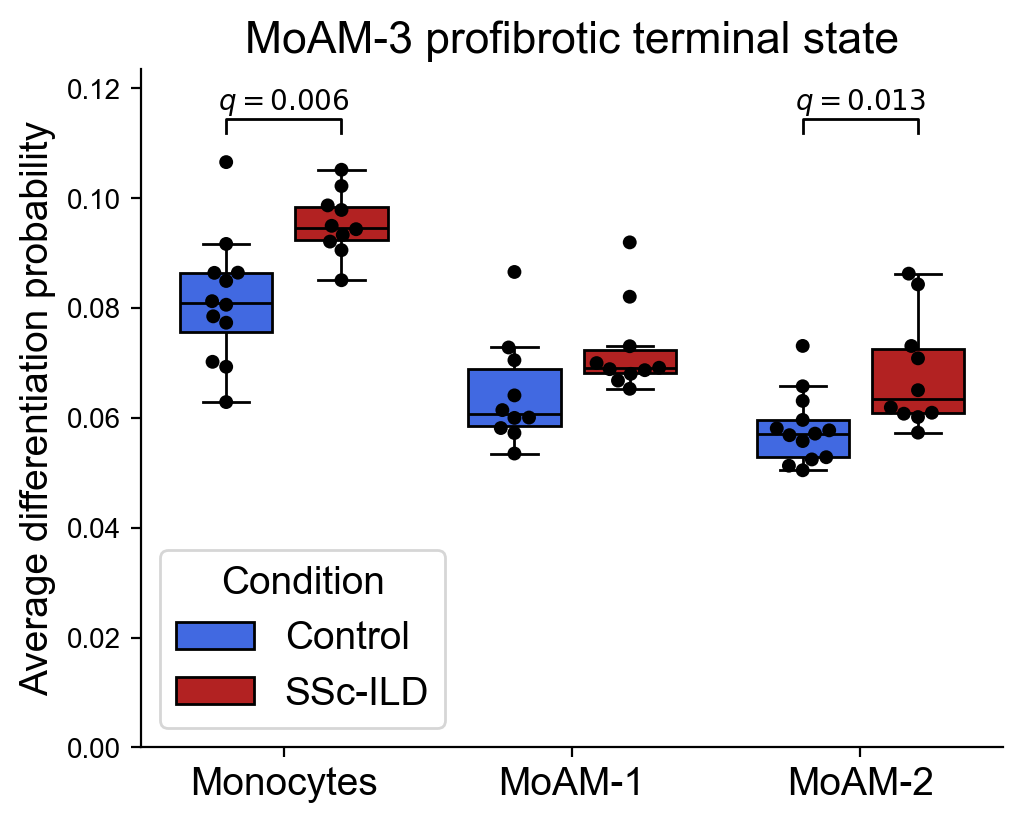

In [74]:
fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
LINEAGE = 'MoAM-3 profibrotic'
df = pseudobulk.merge(metadata_df, left_index=True, right_index=True)
plot_stats_boxplot(ax, df, LINEAGE)
ax.set_title(f'{LINEAGE} terminal state', size=16)
ax.set_ylabel(f'Average differentiation probability', size=14)
ax.set_xlabel('')
ax.tick_params(axis='x', labelsize=14)
ax.set_ylim(0, ax.get_ylim()[1] * 1.05)
h, l = ax.get_legend_handles_labels()
ax.legend(
    handles=h,
    labels=['Control', 'SSc-ILD'],
    loc='lower left',
    fontsize=14,
    title_fontsize=14,
    title='Condition'
)
ax.spines[['top', 'right']].set_visible(False)
fig.savefig('00_figures/Figure_4C_fate_moam.pdf')